C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

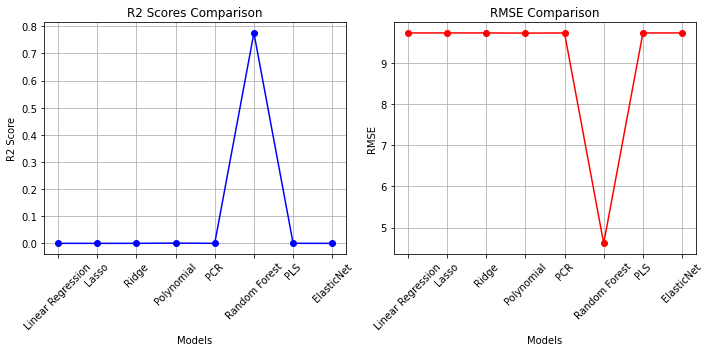

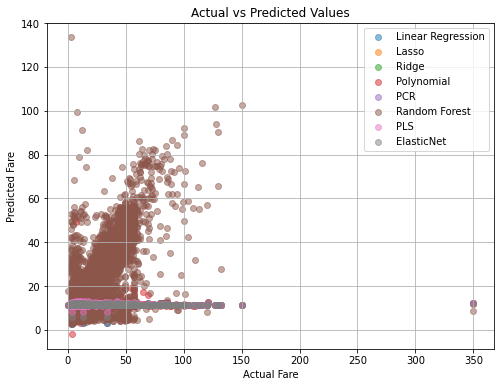

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import statsmodels.api as sm

# Load data
df = pd.read_csv("uber.csv")

# Data pre-processing
df.drop(['Unnamed: 0','key'], axis=1, inplace=True)
df.fillna(method='ffill', inplace=True)
df = df[df['fare_amount'] > 0]
df = df[df['passenger_count'] <= 10]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Define metrics and results tracking
metrics = {}
predictions = []
algorithms = ["Linear Regression", "Random Forest", "XGBRegressor", "ElasticNet", "Logistic Regression", "Poisson Regression", "Negative Binomial"]
r2_scores, rmse_scores = [], []

# Splitting the dataset
features = df[['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'day_of_week']]
target = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Function to store results
def store_results(model_name, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    predictions.append(y_pred)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    metrics[model_name] = {'R2 Score': r2, 'RMSE': rmse}
    print(f"{model_name} - R2: {r2}, RMSE: {rmse}")

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
store_results("Linear Regression", y_pred_lin)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
store_results("Random Forest", y_pred_rf)

# XGBRegressor
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, seed=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)
store_results("XGBRegressor", y_pred_xgb)

# Elastic Net Regression
elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
y_pred_elastic = elastic_net.predict(X_test)
store_results("ElasticNet", y_pred_elastic)

# Logistic Regression (for classification, assuming binary target - for this, you might need a different target)
# For example, let's assume we want to classify high fare vs low fare
df['high_fare'] = (df['fare_amount'] > df['fare_amount'].median()).astype(int)
target_classification = df['high_fare']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(features, target_classification, test_size=0.3, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train_class, y_train_class)
y_pred_logistic = log_reg.predict(X_test_class)
store_results("Logistic Regression", y_pred_logistic)

# Poisson Regression (for regression tasks, assuming count-like target)
poisson_reg = PoissonRegressor(alpha=0.1)
poisson_reg.fit(X_train, y_train)
y_pred_poisson = poisson_reg.predict(X_test)
store_results("Poisson Regression", y_pred_poisson)

# Negative Binomial Regression (using statsmodels)
# Here we assume the target is count data, for simplicity, let's use fare amount rounded as count-like data
target_counts = np.round(df['fare_amount'])
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(features, target_counts, test_size=0.3, random_state=42)
X_train_nb_sm = sm.add_constant(X_train_nb)  # Add constant for statsmodels
X_test_nb_sm = sm.add_constant(X_test_nb)

nb_model = sm.GLM(y_train_nb, X_train_nb_sm, family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()
y_pred_nb = nb_results.predict(X_test_nb_sm)
store_results("Negative Binomial", y_pred_nb)

# Results DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Plotting R2 and RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(algorithms, r2_scores, marker='o', linestyle='-', color='b', label="R2 Score")
plt.title('R2 Scores Comparison')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(algorithms, rmse_scores, marker='o', linestyle='-', color='r', label="RMSE")
plt.title('RMSE Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
for i, algo in enumerate(algorithms):
    plt.scatter(y_test, predictions[i], alpha=0.5, label=algo)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.legend()
plt.grid(True)
plt.show()
